In [1]:
import contextily as cx
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yaml

In [ ]:
def add_tract_ids(
    geo_df: gpd.GeoDataFrame, tract_df: gpd.GeoDataFrame
) -> gpd.GeoDataFrame:
    """
    Adds a column of census tract IDs to a GeoDataFrame based on spatial intersection.

    Parameters:
    geo_df (GeoDataFrame): The input GeoDataFrame with geometries representing walking/multimodal areas.
    socioecon_df (GeoDataFrame): The GeoDataFrame with census tract geometries and tract codes.

    Returns:
    GeoDataFrame: The updated GeoDataFrame with a new column 'tract_code' containing the matched tract codes.
    """

    # Ensure both GeoDataFrames have the same CRS
    if geo_df.crs != tract_df.crs:
        geo_df = geo_df.to_crs(tract_df.crs)

    # Perform spatial join to assign census tract IDs to walking geometries
    geo_tracts = gpd.sjoin(
        geo_df,
        tract_df[["postal_code", "geometry"]],
        how="left",
        predicate="intersects",
    )

    return geo_tracts

In [3]:
with open("../data/crs.yaml", "r") as fp:
    crs = yaml.safe_load(fp)

In [4]:
CITY = "helsinki"
VERSION = "20250428"
YEAR = 2022

In [5]:
output = f"../output/{CITY}/{VERSION}/"
boundary = f"../data/osm/{CITY}/boundary.geojson"

In [6]:
walking = gpd.read_file(f"../output/{CITY}/{VERSION}/isochrones.geojson").set_crs(4326)
walking.to_crs(crs[CITY], inplace=True)

walking15 = walking[(walking["costing"] == "walk") & (walking["range"] == 15)].copy()
walking15.drop(columns=["costing", "range"], inplace=True)

In [7]:
multimodal = gpd.read_file(f"{output}/stop_geometries_from_walk.geojson").set_crs(4326)
multimodal["stop_id"] = multimodal["stop_id"].astype(str)
multimodal.to_crs(crs[CITY], inplace=True)

In [18]:
statistics = gpd.read_file(f"../data/statistics/{CITY}/{YEAR}/statistics.geojson")
gini = gpd.read_file(f"../output/{CITY}/gini.geojson")  # TODO
if CITY == "helsinki":
    # statistics.merge()
    pass
statistics.head(3)

,postal_code,year,name,surface_area,area_name,0-2 years (HE),13-15 years (HE),16-17 years (HE),18-19 years (HE),20-24 years (HE),...,Unemployed (PT),Vocational diploma (KO),"With education, total (KO)","Workplaces, total (TP)",X Industry unknown (TP),X coordinate,Y coordinate,Young couples without children (TE),Young one-person households (TE),geometry
0,00100,2023,Helsinki keskusta - Etu-Töölö,2353278,Helsinki keskusta - Etu-Töölö (Helsinki),352.0,359.0,241.0,318.0,1778.0,...,630.0,1690.0,14143.0,55404.0,0.0,384979.0,6672361.0,816.0,2330.0,"POLYGON ((385653.893 6671591.048, 385779.642 6..."
1,00120,2023,Punavuori - Bulevardi,414010,Punavuori - Bulevardi (Helsinki),139.0,183.0,126.0,116.0,603.0,...,254.0,761.0,5504.0,8069.0,0.0,385531.0,6671434.0,351.0,854.0,"POLYGON ((385316.092 6671076.984, 385388.492 6..."
2,00130,2023,Kaartinkaupunki,428960,Kaartinkaupunki (Helsinki),48.0,54.0,32.0,26.0,137.0,...,47.0,142.0,1292.0,13909.0,1.0,386244.0,6671474.0,66.0,153.0,"POLYGON ((386212.111 6671061.262, 386298.022 6..."


In [9]:
socioecon = pd.read_csv(
    f"../output/{CITY}/socioecon_merged4.csv", dtype={"stop_id": str}
)

In [ ]:
# walking15_tract = add_tract_ids(walking15, statistics)
# walking15_tract["area"] = walking15_tract.geometry.area
# walking15_tract.head(3)

,stop_id,geometry,index_right,postal_code,area
2,1302216,"POLYGON ((382355.996 6675014.352, 382246.415 6...",23,00340,1.145604e+06
2,1302216,"POLYGON ((382355.996 6675014.352, 382246.415 6...",14,00250,1.145604e+06
2,1302216,"POLYGON ((382355.996 6675014.352, 382246.415 6...",22,00330,1.145604e+06


In [11]:
# m = walking15_tract.merge(statistics, on="postal_code", suffixes=["", "_postal"])
# m["ratio"] = m["geometry"].intersection(m["geometry_postal"]).area / m["geometry"].area


# m = m.merge(
#     gini[
#         [
#             "postal_code",
#             "low_inc_est",
#             "high_inc_est",
#             "med_inc",
#             "avg_inc",
#             "gini",
#             "hh_high",
#             "hh_low",
#             "hh_mid",
#         ]
#     ],
#     on="postal_code",
# )

In [11]:
def merge_stop_area_with_statistics(
    stop_areas: gpd.GeoDataFrame, statistics: gpd.GeoDataFrame
) -> gpd.GeoDataFrame:
    mm = (
        stop_areas.sjoin(
            statistics[["postal_code", "geometry"]],
            how="left",
            predicate="intersects",
        )
        .drop(columns="index_right")
        .merge(
            statistics[["postal_code", "geometry"]],
            on="postal_code",
            suffixes=["", "_postal"],
        )
    )
    mm["ratio"] = (
        mm["geometry"].intersection(mm["geometry_postal"]).area / mm["geometry"].area
    )
    return mm


def calculate_weighted_mean(
    x: pd.DataFrame, column: str, weight_column: str
) -> np.float64:
    return np.average(x[column], weights=x[weight_column])


def aggregate_to_stop_area(data: pd.DataFrame, columns: list[str]) -> pd.DataFrame:
    result = pd.DataFrame()
    for i in columns:
        temp = (
            data.groupby("stop_id")
            .apply(
                calculate_weighted_mean,
                column=i,
                weight_column="ratio",
                include_groups=False,
            )
            .reset_index()
            .rename(columns={0: i})
        )
        if result.shape == (0, 0):
            result = temp.copy()
        else:
            result = result.merge(temp, on="stop_id", how="outer")
    return result

In [19]:
mm = merge_stop_area_with_statistics(walking15, statistics)
mm = mm.merge(gini.drop(columns=["name", "geometry"]), on="postal_code")

In [20]:
result_w = aggregate_to_stop_area(
    mm, ["gini", "med_inc", "hh_low", "hh_mid", "hh_high"]
)
result_w.columns = [
    f"weighted_{i}_walk" if i != "stop_id" else i for i in result_w.columns
]

In [21]:
result_w

,stop_id,weighted_gini_walk,weighted_med_inc_walk,weighted_hh_low_walk,weighted_hh_mid_walk,weighted_hh_high_walk
0,1010102,0.302273,49602.794113,826.129204,1983.318622,2030.559451
1,1010103,0.305717,47993.199035,1055.919460,2471.739253,2206.001906
2,1010105,0.309119,46339.511969,1263.165223,2912.289855,2320.121780
3,1010106,0.310345,45760.131449,1342.765247,3081.333557,2396.186991
4,1010107,0.313485,44246.836008,1554.461151,3527.645309,2601.817259
...,...,...,...,...,...,...
2691,1602201,0.243547,82938.000000,53.000000,234.000000,372.000000
2692,1602202,0.243547,82938.000000,53.000000,234.000000,372.000000
2693,1602203,0.243547,82938.000000,53.000000,234.000000,372.000000
2694,1602204,0.243547,82938.000000,53.000000,234.000000,372.000000


In [ ]:
socioecon[result_w.columns].merge(result_w, on="stop_id", suffixes=["_zs", ""]).query(
    "weighted_gini_walk == weighted_gini_walk_zs"
)

,stop_id,weighted_gini_walk_zs,weighted_med_inc_walk_zs,weighted_hh_low_walk_zs,weighted_hh_mid_walk_zs,weighted_hh_high_walk_zs,weighted_gini_walk,weighted_med_inc_walk,weighted_hh_low_walk,weighted_hh_mid_walk,weighted_hh_high_walk
1110,1303102,0.230896,78110.0,74.0,269.0,524.0,0.230896,78110.0,74.0,269.0,524.0
1114,1303107,0.230896,78110.0,74.0,269.0,524.0,0.230896,78110.0,74.0,269.0,524.0
1115,1303108,0.230896,78110.0,74.0,269.0,524.0,0.230896,78110.0,74.0,269.0,524.0
1116,1303111,0.230896,78110.0,74.0,269.0,524.0,0.230896,78110.0,74.0,269.0,524.0
1117,1303112,0.230896,78110.0,74.0,269.0,524.0,0.230896,78110.0,74.0,269.0,524.0
1118,1303113,0.230896,78110.0,74.0,269.0,524.0,0.230896,78110.0,74.0,269.0,524.0
1119,1303114,0.230896,78110.0,74.0,269.0,524.0,0.230896,78110.0,74.0,269.0,524.0
1853,1420105,0.293608,54593.0,274.0,807.0,904.0,0.293608,54593.0,274.0,807.0,904.0
2445,1492100,0.275641,72608.0,145.0,452.0,607.0,0.275641,72608.0,145.0,452.0,607.0
2446,1492103,0.275641,72608.0,145.0,452.0,607.0,0.275641,72608.0,145.0,452.0,607.0


In [23]:
mmm = merge_stop_area_with_statistics(multimodal, statistics)
mmm = mmm.merge(gini.drop(columns=["name", "geometry"]), on="postal_code")

result_m = aggregate_to_stop_area(
    mmm, ["gini", "med_inc", "hh_low", "hh_mid", "hh_high"]
)
result_m.columns = [
    f"weighted_{i}_multi" if i != "stop_id" else i for i in result_m.columns
]

In [24]:
result_m

,stop_id,weighted_gini_multi,weighted_med_inc_multi,weighted_hh_low_multi,weighted_hh_mid_multi,weighted_hh_high_multi
0,1010102,0.308730,46772.815257,1125.341106,2580.744356,2379.450922
1,1010103,0.312478,44339.582702,1351.292146,3033.590130,2046.260013
2,1010105,0.314846,42967.949629,1503.456189,3275.090749,2175.135117
3,1010106,0.309280,46134.242592,1207.371842,2746.144881,2248.199192
4,1010107,0.314952,44195.718639,1218.658525,2693.443746,1806.927866
...,...,...,...,...,...,...
2691,1602201,0.243568,82915.759710,53.711605,235.452497,372.142933
2692,1602202,0.249227,78033.438069,195.571551,539.255761,417.500789
2693,1602203,0.243547,82938.000000,53.000000,234.000000,372.000000
2694,1602204,0.248420,78531.103291,184.499579,511.842148,409.577899


In [48]:
indicators = pd.read_csv(
    f"../output/{CITY}/{VERSION}/merged.csv", dtype={"stop_id": str}
)

In [50]:
indicators.merge(result_w, on="stop_id").merge(result_m, on="stop_id").to_csv(
    f"{output}/indicators_with_socioecon.csv", index=False
)

In [41]:
socioecon.columns

Index(['stop_id', 'weighted_med_inc_multi', 'weighted_med_inc_walk',
       'percent_change_income', 'log_change_income', 'weighted_gini_multi',
       'weighted_gini_walk', 'percent_change_gini', 'log_change_gini',
       'weighted_hh_low_multi', 'weighted_hh_mid_multi',
       'weighted_hh_high_multi', 'entropy_multi', 'weighted_hh_low_walk',
       'weighted_hh_mid_walk', 'weighted_hh_high_walk', 'entropy_walk',
       'percent_change_entropy', 'log_change_entropy', 'area', 'ellipticity',
       'number_of_accessible_stops', 'concave_area', 'distance_betweenness',
       'distance_from_landuse_centroid', 'cultural_institutions_multimodal',
       'drugstores_multimodal', 'groceries_multimodal',
       'healthcare_multimodal', 'parks_multimodal',
       'religious_organizations_multimodal', 'restaurants_multimodal',
       'schools_multimodal', 'services_multimodal',
       'cultural_institutions_walk15', 'drugstores_walk15', 'groceries_walk15',
       'healthcare_walk15', 'parks_wal

In [39]:
socioecon[result_m.columns]

,stop_id,weighted_gini_multi,weighted_med_inc_multi,weighted_hh_low_multi,weighted_hh_mid_multi,weighted_hh_high_multi
0,1010102,0.302761,49133.699590,747.071981,1771.924429,1725.386398
1,1010103,0.306655,46938.055693,959.482438,2171.957787,1560.384122
2,1010105,0.310454,44797.560662,1176.074691,2518.697397,1663.131577
3,1010106,0.303187,48715.493718,817.266033,1906.136779,1664.138420
4,1010107,0.311226,45393.697990,1022.242307,2239.258885,1510.855829
...,...,...,...,...,...,...
2691,1602201,0.243717,82760.614105,58.675679,245.584940,373.140017
2692,1602202,0.269652,60625.609024,697.690130,1618.600432,582.807589
2693,1602203,0.243547,82938.000000,53.000000,234.000000,372.000000
2694,1602204,0.267212,61713.585180,683.444075,1569.115626,555.788373


In [18]:
# m.query("stop_id == '1201132'").plot()

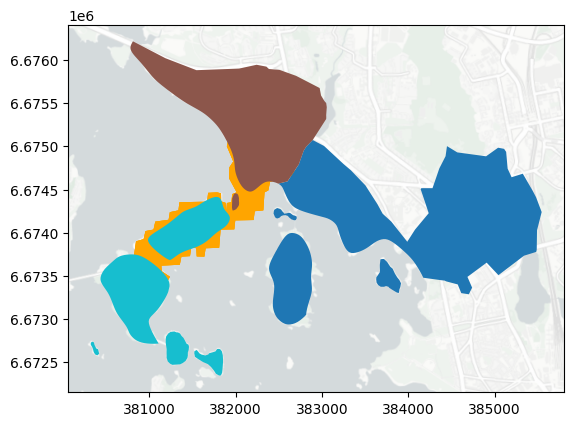

In [20]:
fig, ax = plt.subplots()
mm.query("stop_id == '1302216'").plot(ax=ax, color="orange")
statistics[statistics["postal_code"].isin(["00340", "00250", "00330"])].plot(
    ax=ax, column="postal_code"
)
cx.add_basemap(
    ax,
    crs=crs[CITY],
    source=cx.providers.CartoDB.PositronNoLabels,
    alpha=1,
    attribution=False,
)

In [ ]:
# m = walking15_tract.merge(statistics[["postal_code", "surface_area"]])
# m["ratio"] = m["surface_area"] / m["area"]